In [232]:
from imports import *


# machine learning
from scipy import stats
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score

pd.options.display.max_columns = 100


In [233]:
df = pd.read_csv("cleaned_data/cleaned_wvs_data.csv")

Now, let's train our two linear regressions. This will proceed in three steps:

1) Feature scaling. We will apply StandardScaler to standardize all numeric features. This is important because variables like "trust" are on a much smaller scale when compared to variables like "GDP". Our research question is about measuring feature importance, which means that in order to compare across features, we need them all to have the same scale.

2) Model selection. We train two models --- one a standard OLS linear model, and the second a linear regression with LASSO (L1) regularization. The OLS model will include all regressors of interest. The LASSO model will select only the important features, as the L1 penalty pushes less important coefficients to zero. Note: for our project, it does not make sense to perform dimensionality reduction via PCA on all the numerical variables. This is because PCA loses the interpretability that we are interested in, because it would collapse work_ethic, trust, equality, and religion into its principal components, whcih of course prevents us from determining which of these aspects are the most important.

3) Hyperparameter Tuning for LASSO model. Used 10-fold cross-validation with grid search. Tuned regularization strength (20 values log-spaced from 10^-2 to 10^2). Cross-validation prevents overfitting, because it holds out validation data to prevent leakage. Grid search finds optimal complexity. Log-spaced regularization values test different strengths of L1 penalty.

In [234]:
predictors = ["work_ethic", "trust", "equality", "religion", "gdp_per_capita", "hdi"]

X = df[predictors]
y = df["democracy_score"]

In [235]:
"""
Train OLS model
"""
# set up ols pipeline
ols_pipeline = Pipeline(steps=[
   ('scaler', StandardScaler()),
   ('regressor', LinearRegression())
])

# set up grid search
ols_cv = cross_validate(
    ols_pipeline,
    X, y,
    cv=10,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

mean_mse = -ols_cv['test_score'].mean()
std_mse = ols_cv['test_score'].std()

print(f"OLS Cross-validation MSE: {mean_mse:.3f} (+/- {std_mse:.3f})")

ols_pipeline.fit(X, y)


OLS Cross-validation MSE: 2.478 (+/- 1.560)


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [236]:
"""
Train LASSO Model
"""

seed = 109

# set up lasso pipeline
lasso_pipeline = Pipeline(steps=[
   ('scaler', StandardScaler()),
   ('regressor', Lasso(random_state = seed, max_iter=10000))
])

# define lasso parameter grid
lasso_param_grid = {
    'regressor__alpha': np.logspace(-2, 2, 20)
}

# set up grid search
lasso_cv = GridSearchCV(
    lasso_pipeline,
    lasso_param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

lasso_cv.fit(X, y)

print("LASSO Best Parameters:", lasso_cv.best_params_)
print("LASSO Best Mean Squared Error:", -lasso_cv.best_score_)

LASSO Best Parameters: {'regressor__alpha': np.float64(0.06951927961775606)}
LASSO Best Mean Squared Error: 2.302456088508694


Now, let's begin the analysis and model evaluation. First, here are the coeffficient values for both models.

In [237]:
# get best models / pipelines
best_model_ols = ols_pipeline.named_steps['regressor']
best_pipeline_ols = ols_pipeline
best_model_lasso = lasso_cv.best_estimator_.named_steps['regressor']
best_pipeline_lasso = lasso_cv.best_estimator_

# get coefficients from best models
ols_intercept = best_model_ols.intercept_
ols_coef = best_model_ols.coef_
ols_coef_full = np.concatenate(([ols_intercept], ols_coef))

lasso_intercept = best_model_lasso.intercept_
lasso_coef = best_model_lasso.coef_
lasso_coef_full = np.concatenate(([lasso_intercept], lasso_coef))

# create results dataframes
ols_results = pd.DataFrame({
    'Feature': ['Intercept'] + list(predictors),
    'Coefficient': ols_coef_full
})

lasso_results = pd.DataFrame({
    'Feature': ['Intercept'] + list(predictors),
    'Coefficient': lasso_coef_full
})

# rename features
feature_map = {
    'Intercept': "Intercept",
    'work_ethic': 'Work Ethic',
    'trust': 'Trust',
    'equality': 'Equality',
    'religion': 'Religion',
    'gdp_per_capita': 'GDP Per Capita',
    'hdi': 'Human Development Index',
}

ols_results['Feature'] = ols_results['Feature'].map(feature_map)
lasso_results['Feature'] = lasso_results['Feature'].map(feature_map)

ols_results_sorted = ols_results.sort_values(by='Coefficient', key=abs, ascending=False)
lasso_results_sorted = lasso_results.sort_values(by='Coefficient', key=abs, ascending=False)

print("OLS Coefficients")
display(ols_results_sorted)

print("LASSO Coefficients")
display(lasso_results_sorted)

OLS Coefficients


,Feature,Coefficient
0,Intercept,5.853801
3,Equality,0.907350
6,Human Development Index,0.742764
2,Trust,0.319375
1,Work Ethic,-0.154907
5,GDP Per Capita,-0.102566
4,Religion,0.038507


LASSO Coefficients


,Feature,Coefficient
0,Intercept,5.853801
3,Equality,0.855726
6,Human Development Index,0.652435
2,Trust,0.231709
1,Work Ethic,-0.114564
4,Religion,-0.000000
5,GDP Per Capita,0.000000


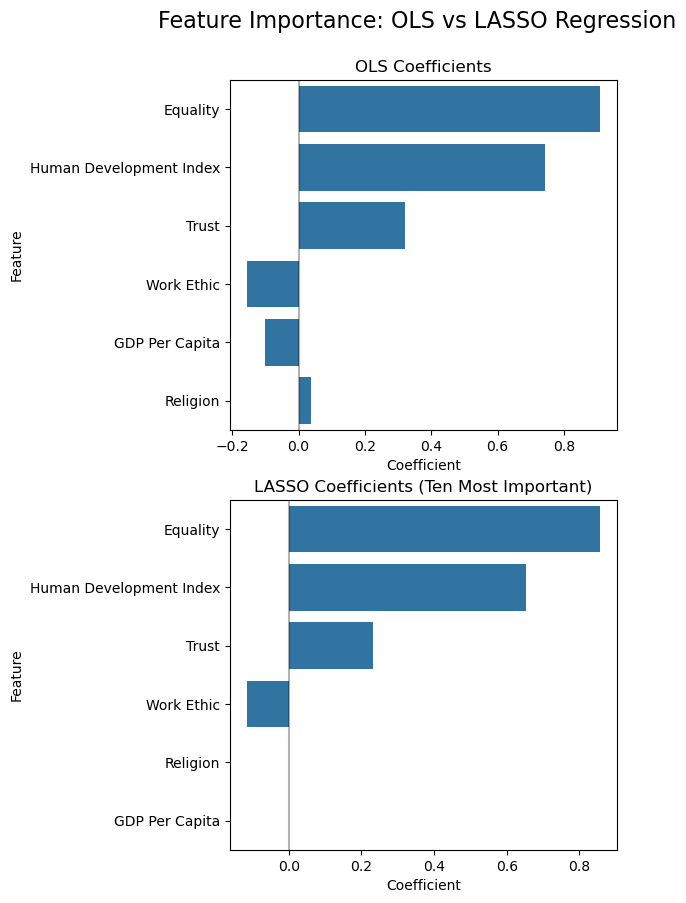

In [238]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
fig.suptitle('Feature Importance: OLS vs LASSO Regression', fontsize=16, y=0.95)

axes = axes.flatten()

# create OLS plot
sns.barplot(data=ols_results_sorted[1:], y='Feature', x='Coefficient', ax=axes[0], orient='h')
axes[0].set_title(f'OLS Coefficients')
axes[0].axvline(0, color='black', alpha=0.3)

sns.barplot(data=lasso_results_sorted[1:11], y='Feature', x='Coefficient', ax=axes[1], orient='h')
axes[1].set_title(f'LASSO Coefficients (Ten Most Important)')
axes[1].axvline(0, color='black', alpha=0.3)


Now, let's calculate the standard errors for the OLS model. [Explain why we aren't calculating standard errors for the LASSO model] We will compute both the analytic confidence intervals for the OLS model and the bootstrapped confidence intervals.

In [260]:
"""
Get analytic confidence intervals
"""
n, p = X.shape
y_pred =  best_pipeline_ols.predict(X)
residuals = y - y_pred

# estimate variance of the error term
s2 = np.sum(residuals ** 2) / (n - p - 1)

# calculate standard errors
X_scaled = best_pipeline_ols.named_steps['scaler'].transform(X)
X_design_ols = np.hstack([np.ones((n, 1)), X_scaled])  # add intercept
se = np.sqrt(s2 * np.diag(np.linalg.inv(X_design_ols.T @ X_design_ols)))

# calculate confidence intervals
z_crit = 1.96
ci_lower_analytic = ols_coef_full - z_crit * se
ci_upper_analytic = ols_coef_full + z_crit * se

# add to OLS results dataframe
ols_results['SE'] = se
ols_results['CI_Lower_Analytic'] = ci_lower_analytic
ols_results['CI_Upper_Analytic'] = ci_upper_analytic


In [261]:
def bootstrap(X, y, pipeline, n_bootstraps=1000):
    """
    Performs bootstrap resampling and returns coefficient estimates for each bootstrap sample.
    - returns an array of shape (n_bootstraps, n_features + 1) containing coefficient estimates for each bootstrap sample, including intercept
    """
    bootstrap_coefs = []
    
    for i in range(n_bootstraps):
        # generate bootstrap sample
        X_bootstrap, y_bootstrap = resample(X, y, random_state=i)
        
        # fit pipeline on bootstrap sample
        pipeline_boot = clone(pipeline)
        pipeline_boot.fit(X_bootstrap, y_bootstrap)
                
        # get coefficients. includes intercept.
        coef_boot = np.concatenate([[pipeline_boot.named_steps['regressor'].intercept_], pipeline_boot.named_steps['regressor'].coef_])
        
        bootstrap_coefs.append(coef_boot)
    
    return np.array(bootstrap_coefs)

In [262]:
"""
Get bootstrap confidence intervals
"""
# get bootstrapped coefficients
ols_coef_bootstrap = bootstrap(X, y, best_pipeline_ols)
bootstrap_distributions = [ols_coef_bootstrap[:, i] for i in range(ols_coef_bootstrap.shape[1])]

# calculate standard errors
se_boot = np.std(ols_coef_bootstrap, axis=0)

# calculate bootstrapped confidence intervals
ci_lower_boot = lasso_coef_full - z_crit * se_boot
ci_upper_boot = lasso_coef_full + z_crit * se_boot

# add to LASSO results dataframe
ols_results['SE_Boot'] = se_boot
ols_results['CI_Lower_Boot'] = ci_lower_boot
ols_results['CI_Upper_Boot'] = ci_upper_boot
ols_results['Bootstrap'] = bootstrap_distributions

display(ols_results)

,Feature,Coefficient,SE,CI_Lower_Analytic,CI_Upper_Analytic,SE_Boot,CI_Lower_Boot,CI_Upper_Boot,Bootstrap
0,Intercept,5.853801,0.086161,5.684926,6.022677,0.129879,5.599238,6.108365,"[5.849662921348315, 5.781573033707865, 5.93559..."
1,Work Ethic,-0.154907,0.096271,-0.343599,0.033785,0.092141,-0.295161,0.066033,"[-0.32502295700439954, -0.2180208133324234, -0..."
2,Trust,0.319375,0.127123,0.070213,0.568536,0.121112,-0.005671,0.469089,"[0.4181987754535804, 0.16344207240512232, 0.30..."
3,Equality,0.907350,0.115218,0.681523,1.133178,0.103586,0.652698,1.058755,"[1.0970028720400578, 0.8753489590295616, 0.987..."
4,Religion,0.038507,0.129077,-0.214483,0.291498,0.163728,-0.320906,0.320906,"[0.2506975561152968, -0.13849873737793206, 0.0..."
5,GDP Per Capita,-0.102566,0.161962,-0.420010,0.214879,0.192832,-0.377950,0.377950,"[-0.5285519443367752, 0.12857891726627366, -0...."
6,Human Development Index,0.742764,0.150313,0.448151,1.037378,0.149475,0.359463,0.945406,"[0.9107247237696268, 0.5628889695437302, 0.788..."


Here are visualizations of the distributions for the bootstrapped LASSO coefficients, along with the bootstrapped confidence intervals.

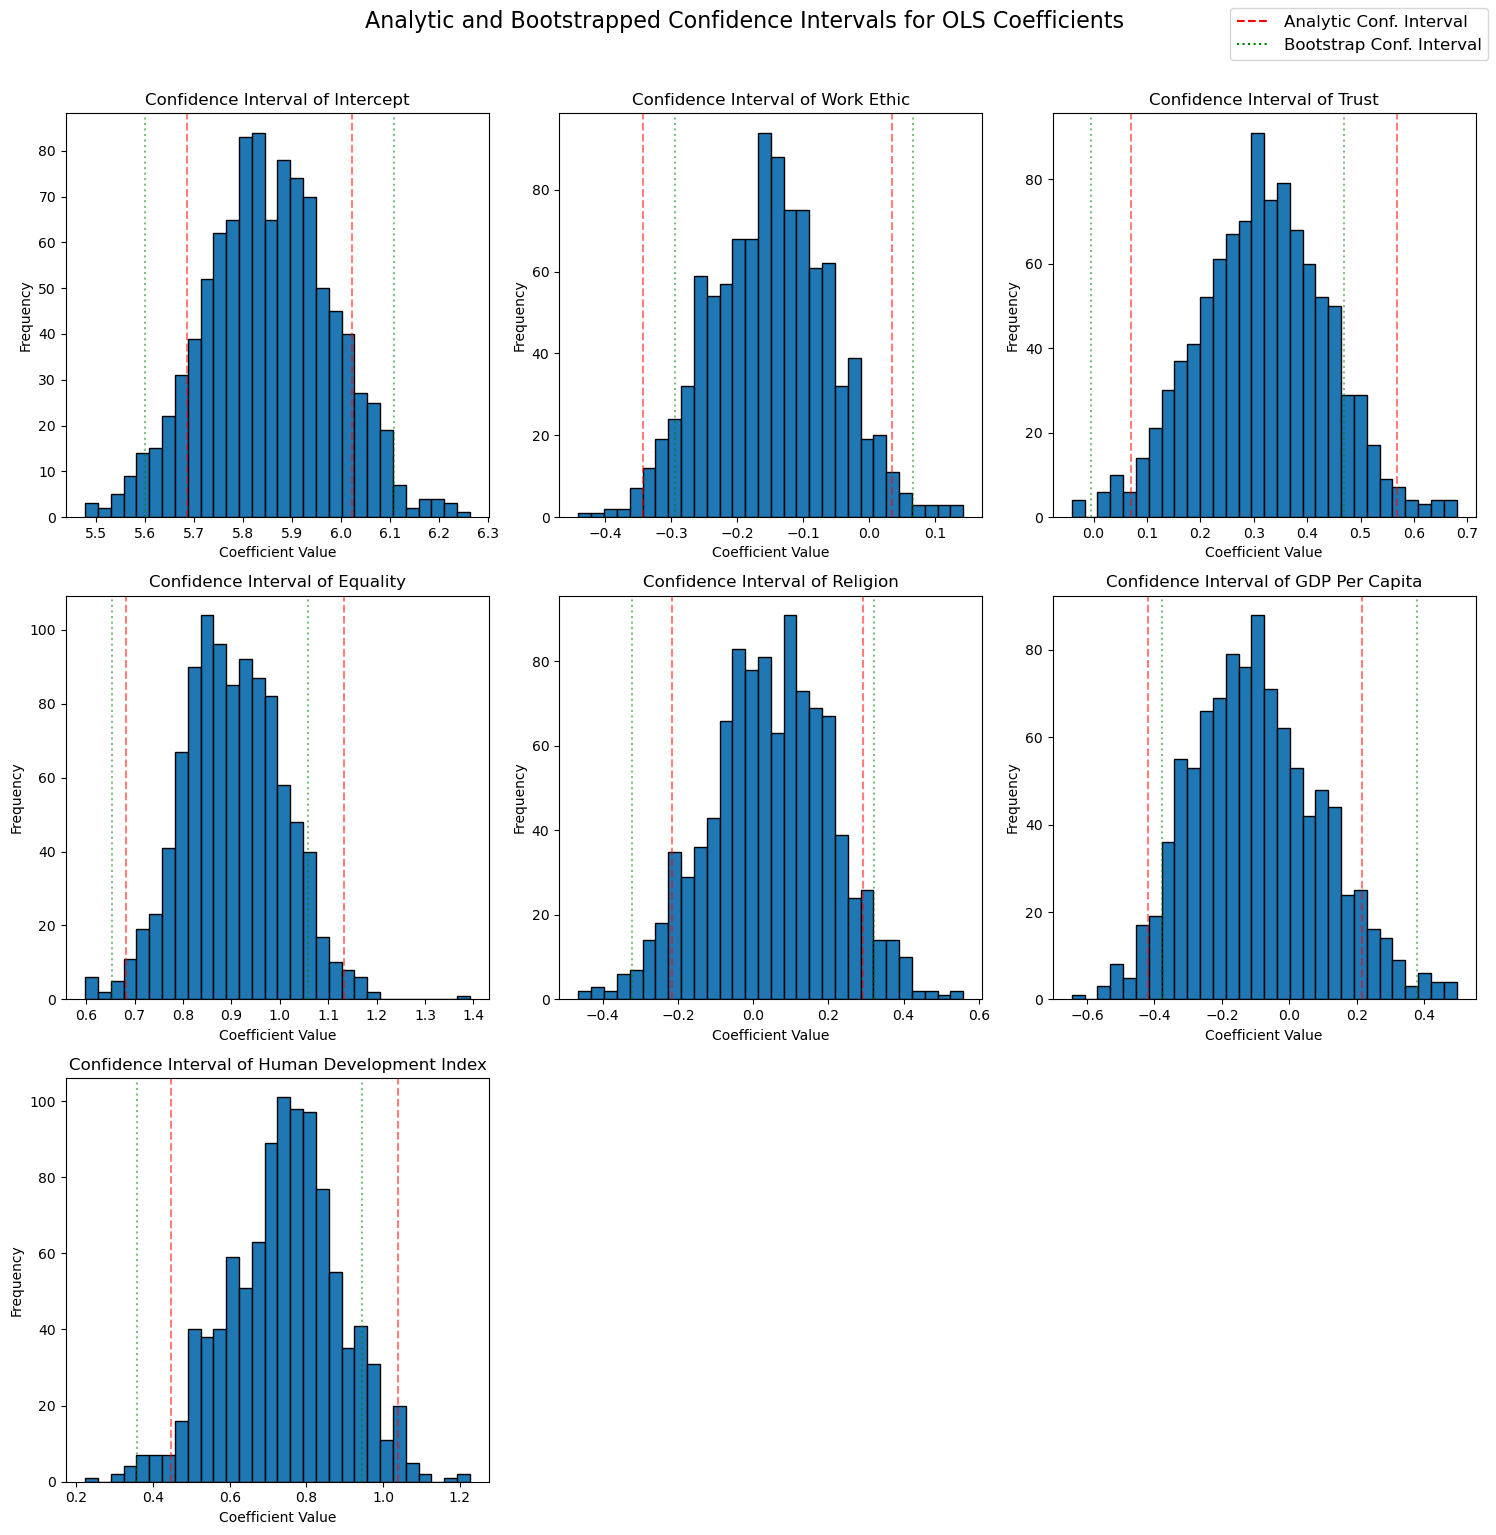

In [257]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Analytic and Bootstrapped Confidence Intervals for OLS Coefficients', fontsize=16, y=1.02)
axes = axes.flatten()

# create legend
legend_elements = [
    plt.Line2D([0], [0], color='r', linestyle='--', label='Analytic Conf. Interval'),
    plt.Line2D([0], [0], color='g', linestyle=':', label='Bootstrap Conf. Interval')
]

# plot histograms for each feature
for i, (idx, row) in enumerate(ols_results.iterrows()):
    feature = row['Feature']
    ci_lower_analytic = row['CI_Lower_Analytic']
    ci_upper_analytic = row['CI_Upper_Analytic']
    ci_lower_boot = row['CI_Lower_Boot']
    ci_upper_boot = row['CI_Upper_Boot']
    coef_dist = row["Bootstrap"]  
      
    # Create histogram
    axes[i].hist(coef_dist, bins=30, edgecolor='black')
    
    # Add vertical lines for confidence intervals
    axes[i].axvline(x=ci_lower_analytic, color='r', linestyle='--', alpha=0.5)
    axes[i].axvline(x=ci_upper_analytic, color='r', linestyle='--', alpha=0.5)
    axes[i].axvline(x=ci_lower_boot, color='g', linestyle=':', alpha=0.5)
    axes[i].axvline(x=ci_upper_boot, color='g', linestyle=':', alpha=0.5)
    
    # Add title and labels
    axes[i].set_title(f'Confidence Interval of {feature}')
    axes[i].set_xlabel('Coefficient Value')
    axes[i].set_ylabel('Frequency')

# Hide empty subplots
for i in range(len(lasso_results), len(axes)):
    axes[i].set_visible(False)

fig.legend(handles=legend_elements, loc='upper right', fontsize = 12)

plt.tight_layout()
plt.show()

Here is a figure that shows the mean squared for the different L1 penalties, and why we chose the penalty size that we did.

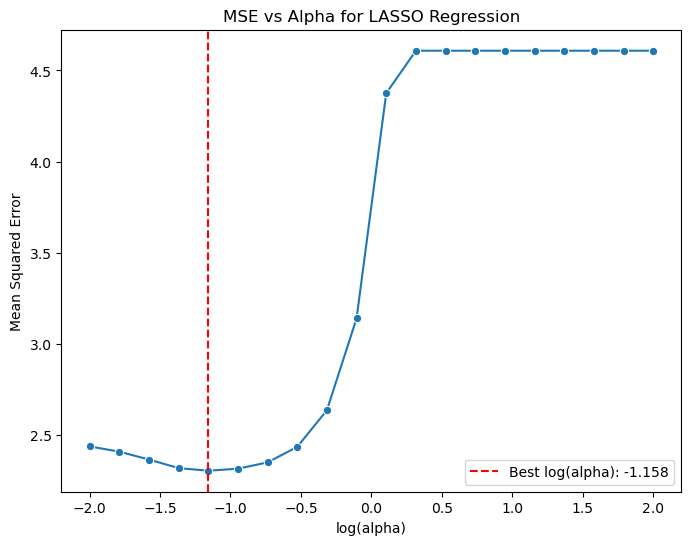

In [ ]:
# get alphas and MSE scores from LASSO grid search results
alphas = lasso_cv.cv_results_['param_regressor__alpha'].data.astype(float)
mse_scores = -lasso_cv.cv_results_['mean_test_score']  # negative because we used neg_mean_squared_error
best_alpha = lasso_cv.best_params_['regressor__alpha']

# create plot
plt.figure(figsize=(8, 6))
sns.lineplot(x=np.log10(alphas), y=mse_scores, marker = 'o', errorbar=None)
plt.axvline(x=np.log10(best_alpha), color='r', linestyle='--', label=f'Best log(alpha): {np.log10(best_alpha):.3f}')
plt.xlabel('log(alpha)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha for LASSO Regression')
plt.legend()
plt.show()

We will also check whether our OLS regression assuptions are satisfied. First, we will see whether the residuals are approximately normally distributed.

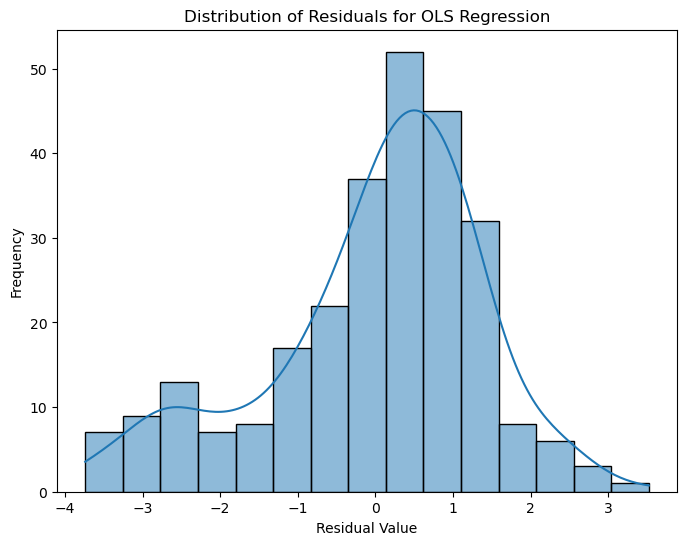

In [259]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals for OLS Regression')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

Next, we will check to see whether the residuals are homoskedastic.

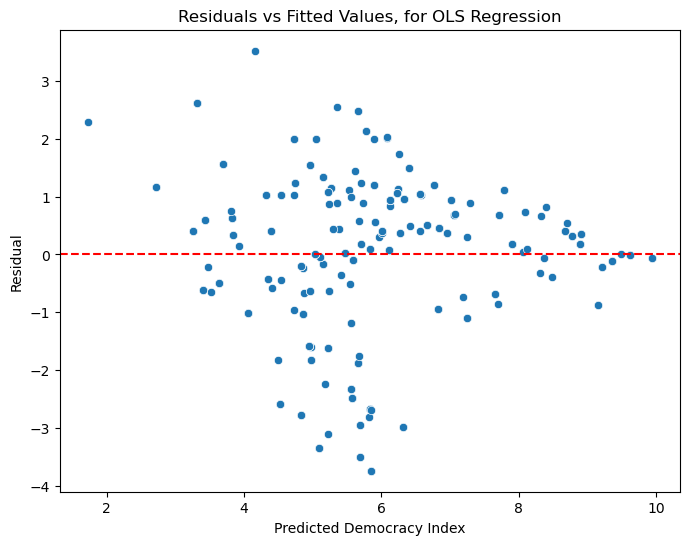

In [258]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values, for OLS Regression')
plt.xlabel('Predicted Democracy Index')
plt.ylabel('Residual')
plt.show()